---
# B&W Image Colorization

### Jamie Santiago & Jane Sieving

### Machine Learning, Fall 2019 @ Olin College
---


# Setup

In [0]:
!pip install torchviz
!pip install Pillow

     |████████████████████████████████| 51kB 3.3MB/s 
  Created wheel for torchviz: filename=torchviz-0.0.1-cp36-none-any.whl size=3520 sha256=191fdde3bb682553bec2fdd327208333d3ba3600c2b4282b4ffa71dc30cd77cd
  Stored in directory: /root/.cache/pip/wheels/2a/c2/c5/b8b4d0f7992c735f6db5bfa3c5f354cf36502037ca2b585667
Successfully built torchviz


In [0]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable
from torchviz import make_dot
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm
import numpy as np
from skimage.color import rgb2lab, lab2rgb
import time
import cv2


%matplotlib inline

from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# Loading & Over-fitting a Single Image
Here, we load a test image and separate the L, A and B channels after converting from RGB. This will allow us to train the model using L (lightness) as input, and A&B (color channels) as output.

In [0]:
Lmap = LinearSegmentedColormap.from_list('Lmap', ["black", "white"])
Amap = LinearSegmentedColormap.from_list('Amap', [(0, 1, .4), (1, 0, .5)]) # green, red
Bmap = LinearSegmentedColormap.from_list('Bmap', [(0, .4, 1), (1, 1, 0)]) # blue, yellow

cm.register_cmap(name = "Lmap", cmap = Lmap)
cm.register_cmap(name = "Amap", cmap = Amap)
cm.register_cmap(name = "Bmap", cmap = Bmap)

w, h = 224, 224

def separate(pixels, disp = False):
    pixels = pixels.resize((w, h), resample=Image.LANCZOS)
    
    lab = rgb2lab(pixels)

    l = lab[:, :, 0]
    a = lab[:, :, 1]
    b = lab[:, :, 2]
    
    if disp:      
        plt.subplot(1, 4, 1)
        plt.imshow(pixels)

        plt.subplot(1, 4, 2)
        plt.imshow(l, cmap = Lmap)

        plt.subplot(1, 4, 3)
        plt.imshow(a, cmap = Amap)

        plt.subplot(1, 4, 4)
        plt.imshow(b, cmap = Bmap)
        
    x = np.ndarray((1, 1, w, h), dtype = np.float32) # make a 4D numpy array compatible with a tensor
    x[0, 0, :, :] = l # copy in the L data to the 4D array
    x = torch.from_numpy(x) # create a tensor
    
    y = np.ndarray((1, 2, w, h), dtype = np.float32) # make a 4D numpy array compatible with a tensor
    y[0, 0, :, :] = a # copy in the L data to the 4D array
    y[0, 1, :, :] = b # copy in the L data to the 4D array
    y = torch.from_numpy(y) # create a tensor
    
    return x, y

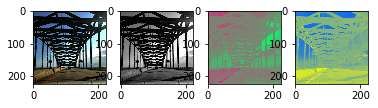

In [0]:
test_image = Image.open("/content/bridge.jpg")

l, ab = separate(test_image, disp = True)

## Creating a Convolutional Neural Network
We based the architecture of this model off of simplified versions of the models used by Zhang et al. and Emil Wallner. During testing, we introduced a multiplier "k" for the number of kernels (filters) in each layer, which sped up learning for small data samples. Originally, k was equivalent to 64 in the model we based our on. We concluded that more information was not very helpful on small sets, although it may be necessary for the full dataset in a working model.

Model architecture: https://richzhang.github.io/colorization/

Simplified loss/error comparing: https://blog.floydhub.com/colorizing-b-w-photos-with-neural-networks/

In [0]:
class Colorizer(nn.Module):
    # The init funciton in Pytorch classes is used to keep track of the parameters of the model
    # specifically the ones we want to update with gradient descent + backprop
    # So we need to make sure we keep track of all of them here
    def __init__(self, k = 64):
        super(Colorizer, self).__init__()
    
        self.k = k # 16 or 32 are similarly fast at learning/good, 64 learns slowly
                
        self.conv1_1 = nn.Conv2d(1, k, kernel_size=3, stride=1, padding=1, dilation = 1)
        self.conv1_2 = nn.Conv2d(k, k, kernel_size=3, stride=2, padding=1, dilation = 1)
        self.norm1 = nn.BatchNorm2d(k)
        
        self.conv2_1 = nn.Conv2d(k, k*2, kernel_size=3, stride=1, padding=1, dilation = 1)
        self.conv2_2 = nn.Conv2d(k*2, k*2, kernel_size=3, stride=2, padding=1, dilation = 1)
        self.norm2 = nn.BatchNorm2d(k*2)
        
        self.conv3_1 = nn.Conv2d(k*2, k*4, kernel_size=3, stride=1, padding=1, dilation = 1)
        self.conv3_2 = nn.Conv2d(k*4, k*4, kernel_size=3, stride=1, padding=1, dilation = 1)
        self.conv3_3 = nn.Conv2d(k*4, k*4, kernel_size=3, stride=2, padding=1, dilation = 1)
        self.norm3 = nn.BatchNorm2d(k*4)
        
        self.conv4_1 = nn.Conv2d(k*4, k*8, kernel_size=3, stride=1, padding=1, dilation = 1)
        self.conv4_2 = nn.Conv2d(k*8, k*8, kernel_size=3, stride=1, padding=1, dilation = 1)
        self.conv4_3 = nn.Conv2d(k*8, k*8, kernel_size=3, stride=1, padding=1, dilation = 1)
        self.norm4 = nn.BatchNorm2d(k*8)
        
        self.conv5_1 = nn.Conv2d(k*8, k*8, kernel_size=3, stride=1, padding=2, dilation = 2)
        self.conv5_2 = nn.Conv2d(k*8, k*8, kernel_size=3, stride=1, padding=2, dilation = 2)
        self.conv5_3 = nn.Conv2d(k*8, k*8, kernel_size=3, stride=1, padding=2, dilation = 2)
        self.norm5 = nn.BatchNorm2d(k*8)
        
        self.conv6_1 = nn.Conv2d(k*8, k*8, kernel_size=3, stride=1, padding=2, dilation = 2)
        self.conv6_2 = nn.Conv2d(k*8, k*8, kernel_size=3, stride=1, padding=2, dilation = 2)
        self.conv6_3 = nn.Conv2d(k*8, k*8, kernel_size=3, stride=1, padding=2, dilation = 2)
        self.norm6 = nn.BatchNorm2d(k*8)
        
        self.conv7_1 = nn.Conv2d(k*8, k*4, kernel_size=3, stride=1, padding=1, dilation = 1)
        self.conv7_2 = nn.Conv2d(k*4, k*4, kernel_size=3, stride=1, padding=1, dilation = 1)
        self.conv7_3 = nn.Conv2d(k*4, k*4, kernel_size=3, stride=1, padding=1, dilation = 1)
        self.norm7 = nn.BatchNorm2d(k*4)
        
        self.ups = nn.Upsample(scale_factor=2)
        # conv8_1 should have stride = .5, used upsampling instead
        self.conv8_1 = nn.Conv2d(k*4, k*2, kernel_size=3, stride=1, padding=1, dilation = 1)
        self.conv8_2 = nn.Conv2d(k*2, k*2, kernel_size=3, stride=1, padding=1, dilation = 1)
        self.conv8_3 = nn.Conv2d(k*2, k*2, kernel_size=3, stride=1, padding=1, dilation = 1)
        
        self.squish = nn.Conv2d(k*2, 2, kernel_size=1, stride=1)
        self.ups2 = nn.Upsample(scale_factor= 4)

    def forward(self, x):       
        x = self.conv1_1(x)
        x = self.conv1_2(x)
        x = self.norm1(x)
                
        x = self.conv2_1(x)
        x = self.conv2_2(x)
        x = self.norm2(x)
                
        x = self.conv3_1(x)
        x = self.conv3_2(x)
        x = self.conv3_3(x)
        x = self.norm3(x)
                
        x = self.conv4_1(x)
        x = self.conv4_2(x)
        x = self.conv4_3(x)
        x = self.norm4(x)
                
        x = self.conv5_1(x)
        x = self.conv5_2(x)
        x = self.conv5_3(x)
        x = self.norm5(x)
                
        x = self.conv6_1(x)
        x = self.conv6_2(x)
        x = self.conv6_3(x)
        x = self.norm6(x)
                
        x = self.conv7_1(x)
        x = self.conv7_2(x)
        x = self.conv7_3(x)
        x = self.norm7(x)
                
        x = self.ups(x)
        x = self.conv8_1(x)
        x = self.conv8_2(x)
        x = self.conv8_3(x)
                
        x = self.squish(x)
        x = self.ups2(x)
                
        return x

    def get_loss(self, learning_rate):
      # Loss function
        loss = nn.MSELoss()
      # Optimizer, self.parameters() returns all the Pytorch operations that are attributes of the class
        optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        return loss, optimizer

## Training to Over-fit and Comparing Results

In [0]:
def overfit_single(net, image, n_epochs = 50, learning_rate = 5e-3):
    """ Train the network to be overfitted on a particular image.
    This function has been used to evaluate the model at several stages. Recording
    time helped us estimate how long it would take to train on many images, and 
    later, the function was modified to return the images for each epoch as a
    visual way to evaluate training effectiveness and loss over time.
    """ 
    loss, optimizer = net.get_loss(learning_rate)
    images = []
    
    gray, color = separate(image)
    gray, color = Variable(gray).to(device), Variable(color).to(device)

    # Loop for n_epochs
    start_time = time.time()
    for epoch in range(n_epochs):
        # get sample in & out = color, gray
        
        # In Pytorch, We need to always remember to set the optimizer gradients to 0 before we recompute the new gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = net(gray)
        images.append(outputs)

        # Compute the loss and find the loss with respect to each parameter of the model
        loss_size = loss(outputs, color)
        loss_size.backward()
        if epoch % 10 == 0:
            print(epoch, loss_size.data.item())

        # Change each parameter with respect to the recently computed loss.
        optimizer.step()
    
    time_per = (time.time() - start_time) / n_epochs
    print("Training took {:.2f}s per epoch".format(time_per))

    return images

def predict_compare_demo(orig, est, show_l = False):
    '''Takes in an orignal RGB image (with channel-last dimension order) and a 
    predicted LAB image (with channel first) and compares them side by side. If
    'show_l' is false, both images are displayed with the lightness averaged, so
    that the A and B channels are more apparent. This was done because it is
    easy to look at an image with poor A&B channel painting and be tricked by
    the completely accurate lightness that the estimate is not that far off.'''

    ab = est[0].numpy()
    
    orig = orig.resize((w, h), resample=Image.LANCZOS)
    lab_orig = rgb2lab(orig)

    if show_l:
        l = lab_orig[:, :, 0]
    else:
        l = np.mean(lab_orig[:, :, 0])
        lab_orig[:, :, 0] = l

    lab_est = np.ndarray((224, 224, 3))
    lab_est[:, :, 0] = l
    lab_est[:, :, 1] = ab[0, :, :]
    lab_est[:, :, 2] = ab[1, :, :]

    rgb_orig = lab2rgb(lab_orig)
    rgb_est = lab2rgb(lab_est)

    plt.subplot(1, 2, 1)
    plt.imshow(rgb_orig)
    
    plt.subplot(1, 2, 2)
    plt.imshow(rgb_est)

## Trying it Out

In [0]:
# Define what device we want to use
device = 'cuda' # 'cpu' if we want to not use the gpu
# Initialize the model, loss, and optimization function
simplenet = Colorizer(k = 16)
# This tells our model to send all of the tensors and operations to the GPU (or keep them at the CPU if we're not using GPU)
simplenet.to(device)

print("")

In [0]:
# This will show the loss after each epoch.
images = overfit_single(simplenet, test_image, n_epochs = 400, learning_rate = 1e-4)

0 131.84922790527344
10 116.57138061523438
20 94.57523345947266
30 69.04255676269531
40 58.474857330322266
50 53.29706954956055
60 49.35856246948242
70 47.11264419555664
80 44.294105529785156
90 42.02988815307617
100 40.44136047363281
110 38.97187805175781
120 38.774688720703125
130 36.66973876953125
140 35.45347213745117
150 34.504798889160156
160 33.766151428222656
170 33.524532318115234
180 32.747825622558594
190 32.13481903076172
200 31.588333129882812
210 31.37021255493164
220 30.725116729736328
230 30.20286750793457
240 29.66996192932129
250 29.16055679321289
260 29.264474868774414
270 28.252498626708984
280 27.700946807861328
290 27.23036003112793
300 26.86545181274414
310 26.45760726928711
320 26.09337615966797
330 25.858726501464844
340 25.667869567871094
350 25.32076644897461
360 25.074371337890625
370 24.85250473022461
380 24.670068740844727
390 24.527603149414062
Training took 0.04s per epoch


## Comparing Result Evolution vs. Training Epochs

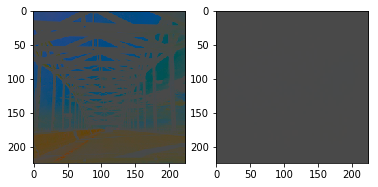

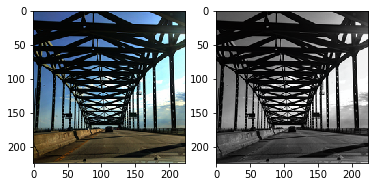

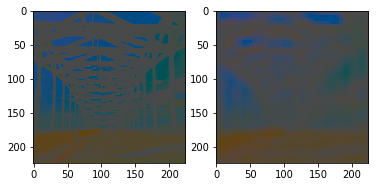

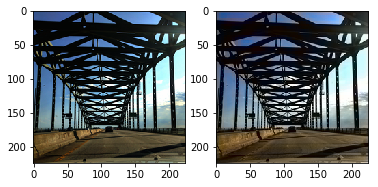

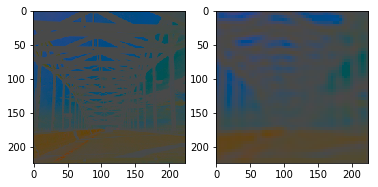

/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:988: UserWarning: Color data out of range: Z < 0 in 1 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


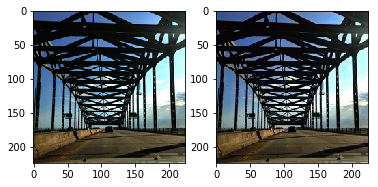

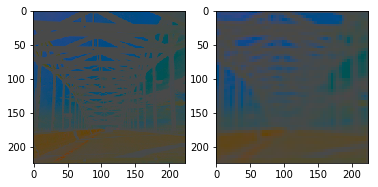

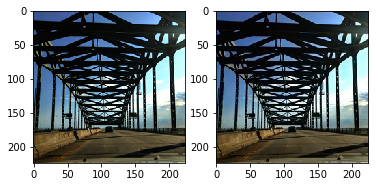

In [0]:
''' Several experiments with this showed a couple of things:
Setting k (kernel count multiplier) to 64 results in very slow learning.
Setting it to 16 produces great results quickly. 32 may be slightly
better quality, and not tremendously slower.

A low learning rate is amazing. 1e-4 seems to get quick, high-accuracy
results, and re-training a trained model with 1e-5 or 1e-6 can get closer
on small, unusual details (like taking eyes from grayish to blue).
'''

result = images[1].detach().cpu()
predict_compare_demo(test_image, result)
plt.show()
predict_compare_demo(test_image, result, show_l=True)
plt.show()

result = images[99].detach().cpu()
predict_compare_demo(test_image, result)
plt.show()
predict_compare_demo(test_image, result, show_l=True)
plt.show()

result = images[199].detach().cpu()
predict_compare_demo(test_image, result)
plt.show()
predict_compare_demo(test_image, result, show_l=True)
plt.show()

result = images[399].detach().cpu()
predict_compare_demo(test_image, result)
plt.show()
predict_compare_demo(test_image, result, show_l=True)
plt.show()

## Inspecting Layer Activations
For each layer, only one kernel/filter is displayed. Different ones can be viewed by changing the number on line 23. Note: Some layers may have as few as 16 filters.

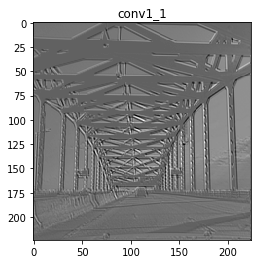

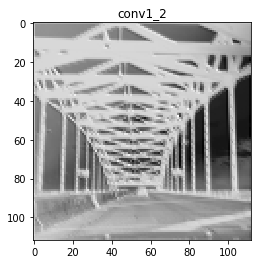

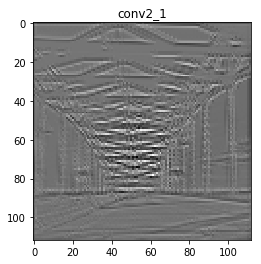

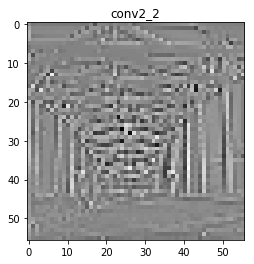

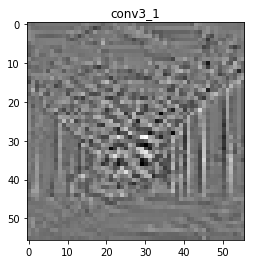

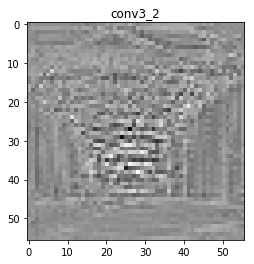

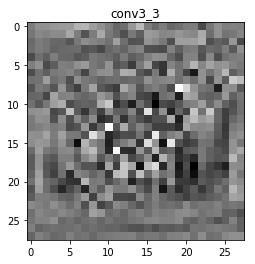

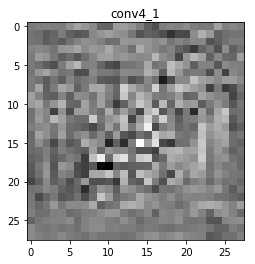

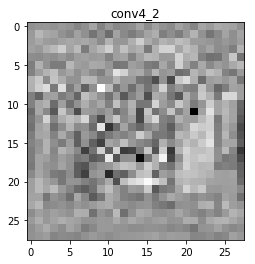

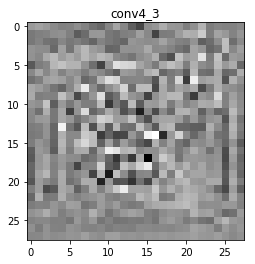

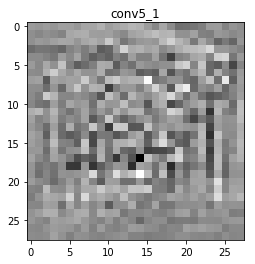

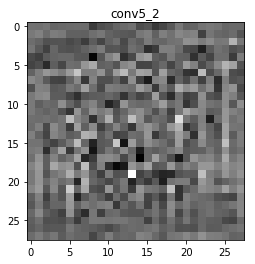

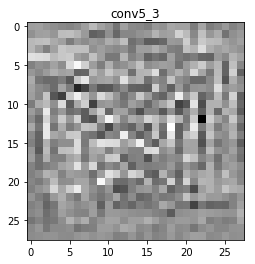

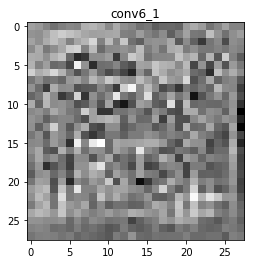

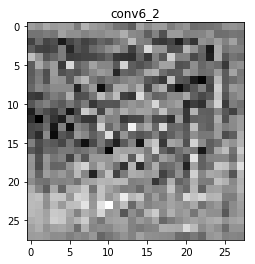

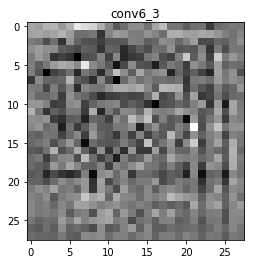

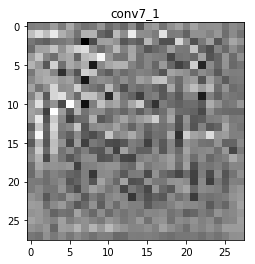

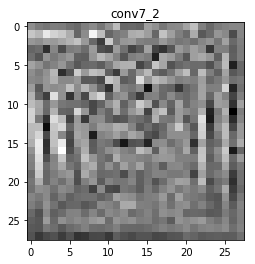

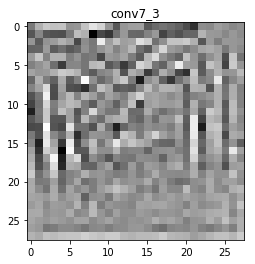

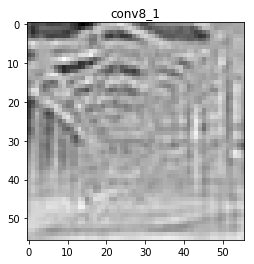

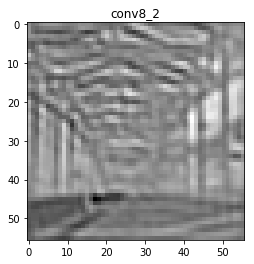

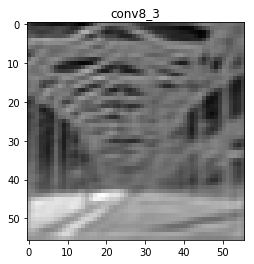

In [0]:
gray, _ = separate(test_image)
gray = Variable(gray).to(device)

# Visualize feature maps
layer_names = ['conv1_1', 'conv1_2', 'conv2_1', 'conv2_2', 
          'conv3_1', 'conv3_2', 'conv3_3', 'conv4_1', 'conv4_2', 'conv4_3',
          'conv5_1', 'conv5_2', 'conv5_3', 'conv6_1', 'conv6_2', 'conv6_3',
          'conv7_1', 'conv7_2', 'conv7_3', 'conv8_1', 'conv8_2', 'conv8_3']

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

for name in layer_names:
    layer = getattr(simplenet, name)
    layer.register_forward_hook(get_activation(name))

    output = simplenet(gray)

    act = activation[name].squeeze()
    plt.imshow(act[8].cpu(), cmap=Lmap) # this only shows 1 filter for each layer!
    plt.title(name)
    plt.show()

# Loading & Training on a Database

We load data from this dataset: https://www.kaggle.com/shravankumar9892/image-colorization

In [0]:
r = input("Want to load these files again?\n> ")
if r == "y":
    with open("/content/drive/My Drive/CNN colorize Data/ab/ab1.npy", 'rb') as f: #opens ab1.npy and sets it to ab1 10K
        ab1 = np.load(f)
#     with open("/content/drive/My Drive/CNN colorize Data/ab/ab2.npy", 'rb') as f: #opens ab2.npy and sets it to ab2 10K
#         ab2 = np.load(f)
#     with open("/content/drive/My Drive/CNN colorize Data/ab/ab3.npy", 'rb') as f: #opens ab3.npy and sets it to ab3 5K
#         ab3 = np.load(f)
    with open("/content/drive/My Drive/CNN colorize Data/gray_scale.npy", 'rb') as f: #opens gray_scale.npy and sets it to gs 25K
        gs = np.load(f)

Want to load these files again?
> y


In [0]:
# Originally, we concatenated the 3 ab sets together, but for testing with smaller samples, we just use a few images. 
# ab = np.concatenate((ab1, ab2, ab3))

tiny_ab = ab1[:2000]
tiny_gs = gs[:2000]

## Creating a Dataset Class to Handle Data

In [0]:
class ImageTraining(torch.utils.data.Dataset):
    def __init__(self, grayscale, ab): #Takes the gray images and color images
        self.grayscale = grayscale
        self.ab = ab
    
    def __len__(self):
        return len(self.grayscale)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        gray_image = self.grayscale[idx]
        ab_image =  self.ab[idx]
        
        x = np.ndarray((1, w, h), dtype = np.float32) # make a 3D numpy array compatible with a tensor
        x[0, :, :] = gray_image # copy in the L data to the 3D array
        
        y = np.ndarray((2, w, h), dtype = np.float32) # make a 3D numpy array compatible with a tensor
        y[0, :, :] = ab_image[:, :, 0] # copy in the A data to the 3D array
        y[1, :, :] = ab_image[:, :, 1] # copy in the B data to the 3D array
        
        sample = {'gray' : x, 'ab_image' : y}

        return sample

## Creating a Training Function for More Images

In [0]:
def train_model(net, batch_size, learning_rate, n_epochs, run_test = False):
    """ Train a the specified network.

    """ 
    loss, optimizer = net.get_loss(learning_rate)
    
    print_every = len(train_set)//batch_size//2
    idx = 0
    train_hist_x = []
    train_loss_hist = []
    test_hist_x = []
    test_loss_hist = []
    
    training_start_time = time.time()

    # Loop for n_epochs
    for epoch in range(n_epochs):
        running_loss = 0.0
        start_time = time.time()
        
        for i, data in enumerate(train_loader, 0):
            gray = data['gray']
            color = data['ab_image']
            color, gray = Variable(color).to(device), Variable(gray).to(device)

            # In Pytorch, We need to always remember to set the optimizer gradients to 0 before we recompute the new gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = net(gray)

            # Compute the loss and find the loss with respect to each parameter of the model
            loss_size = loss(outputs, color)
            loss_size.backward()

            # Change each parameter with respect to the recently computed loss.
            optimizer.step()
            
            running_loss += loss_size.data.item()
            
            if (i % print_every) == print_every-1:
                print("Epoch {}, Iteration {}\t train_loss: {:.2f} took: {:.2f}s".format(
                    epoch + 1, i+1,running_loss / print_every, time.time() - start_time))
                # Reset running loss and time
                train_loss_hist.append(running_loss / print_every)
                train_hist_x.append(idx)
                running_loss = 0.0
                start_time = time.time()
            idx += 1

        if run_test:
            # At the end of the epoch, do a pass on the test set
            total_test_loss = 0
            for data in test_loader:
                
                gray = data['gray']
                color = data['ab_image']
                labels, inputs = Variable(color).to(device), Variable(gray).to(device)

                # Forward pass
                test_outputs = net(inputs)
                test_loss_size = loss(test_outputs, labels)
                total_test_loss += test_loss_size.data.item()
            test_loss_hist.append(total_test_loss / len(test_loader))
            test_hist_x.append(idx)
            print("Validation loss = {:.2f}".format(
                total_test_loss / len(test_loader)))
    
    print("Training finished, took {:.2f}s".format(
        time.time() - training_start_time))
    return train_hist_x, train_loss_hist, test_hist_x, test_loss_hist

## Setting up the training parameters

In [0]:
# Data set information
n_samples = 1000 # How many images to use for each of train and test
batch_size = 5
learning_rate = 1e-4
n_epochs = 10
k = 32

# Load the training set
train_set = ImageTraining(tiny_gs[:n_samples], tiny_ab[:n_samples])
train_sampler = SubsetRandomSampler(np.arange(n_samples, dtype=np.int64))

#Load the test set
test_set = ImageTraining(tiny_gs[n_samples:n_samples*2], tiny_ab[n_samples:n_samples*2])
test_sampler = SubsetRandomSampler(np.arange(n_samples, dtype=np.int64))

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                           sampler=train_sampler, num_workers=2)

test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=batch_size, sampler=test_sampler, num_workers=2)

## Instantiating a Network

In [0]:
# Define what device we want to use
device = 'cuda' # 'cpu' if we want to not use the gpu
# Initialize the model, loss, and optimization function
net = Colorizer(k=k)
# This tells our model to send all of the tensors and operations to the GPU (or keep them at the CPU if we're not using GPU)
net.to(device)

print("")

## Running, plotting, and saving the training results

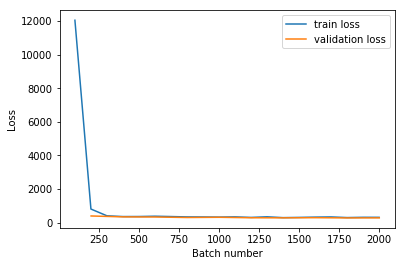

In [0]:
train_hist_x, train_loss_hist, test_hist_x, test_loss_hist = train_model(net, batch_size, learning_rate, n_epochs, run_test=True)
filepath = "/content/drive/My Drive/CNN colorize Data/models/a32-tiny1000-b5-l1e4-e10.tar"

loss, optimizer = net.get_loss(learning_rate)

torch.save({
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss}, 
            filepath)

plt.plot(train_hist_x,train_loss_hist)
plt.plot(test_hist_x,test_loss_hist)
plt.legend(['train loss', 'validation loss'])
plt.xlabel('Batch number')
plt.ylabel('Loss')
plt.show()

## Visualizing model output for particular images

In [0]:
def show_prediction(idx, set, net):
    
    data = set.__getitem__(idx)
    
    # get original grey data
    l = data['gray']
    
    # get a prediction from the grey data
    inputs = np.ndarray((1, 1, 224, 224), dtype = np.float32)
    inputs[0, 0, :, :] = l
    inputs = torch.from_numpy(inputs) # create a tensor
    inputs = Variable(inputs).to(device)

    output = net(inputs)
    output = output.detach().cpu()
    ab_pred = output[0].numpy()
    
    # get original color (AB) data
    ab_real = data['ab_image']
    
    # create complete LAB images for original and prediction
    lab_pred = np.concatenate((l, ab_pred))
    lab_real = np.concatenate((l, ab_real))
    
    # images need to be rearranged for display (np.reshape did not work as needed)
    l_img = np.ndarray((224, 224))

    ab_pred_img = np.ndarray((224, 224, 3))
    ab_real_img = np.ndarray((224, 224, 3))
    lab_pred_img = np.ndarray((224, 224, 3))
    lab_real_img = np.ndarray((224, 224, 3))
    
    l_img[:, :] = l[0, :, :]

    ab_pred_img[:, :, 0] = np.mean(l)
    ab_pred_img[:, :, 1] = ab_pred[0, :, :]
    ab_pred_img[:, :, 2] = ab_pred[1, :, :]
    
    ab_real_img[:, :, 0] = np.mean(l)
    ab_real_img[:, :, 1] = ab_real[0, :, :]
    ab_real_img[:, :, 2] = ab_real[1, :, :]
    
    
    lab_pred_img[:, :, 0] = lab_pred[0, :, :]
    lab_pred_img[:, :, 1] = lab_pred[1, :, :]
    lab_pred_img[:, :, 2] = lab_pred[2, :, :]
    
    lab_real_img[:, :, 0] = lab_real[0, :, :]
    lab_real_img[:, :, 1] = lab_real[1, :, :]
    lab_real_img[:, :, 2] = lab_real[2, :, :]
    
    ab_pred_img = ab_pred_img.astype('uint8')
    ab_real_img = ab_real_img.astype('uint8')
    lab_pred_img = lab_pred_img.astype('uint8')
    lab_real_img = lab_real_img.astype('uint8')
    rgb_pred_img1 = cv2.cvtColor(ab_pred_img, cv2.COLOR_LAB2RGB)
    rgb_real_img1 = cv2.cvtColor(ab_real_img, cv2.COLOR_LAB2RGB)
    rgb_pred_img2 = cv2.cvtColor(lab_pred_img, cv2.COLOR_LAB2RGB)
    rgb_real_img2 = cv2.cvtColor(lab_real_img, cv2.COLOR_LAB2RGB)
        
    
    plt.subplot(1, 2, 1)
    plt.imshow(rgb_real_img1)

    plt.subplot(1, 2, 2)
    plt.imshow(rgb_pred_img1)
    plt.show()

    plt.subplot(1, 2, 1)
    plt.imshow(rgb_real_img2)

    plt.subplot(1, 2, 2)
    plt.imshow(rgb_pred_img2)
    plt.title(idx)
    plt.show()

In [0]:
for i in range(min(15, n_samples)):
    show_prediction(i, train_set, net)

for i in range(min(15, n_samples)):
    show_prediction(i, test_set, net)

## Loading old models to judge their output

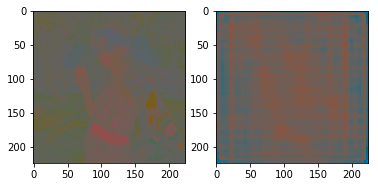

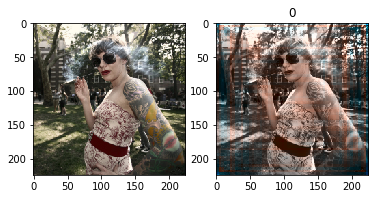

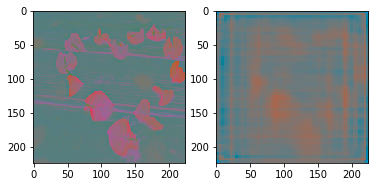

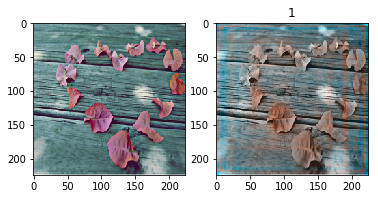

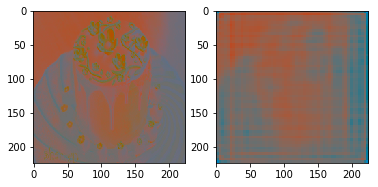

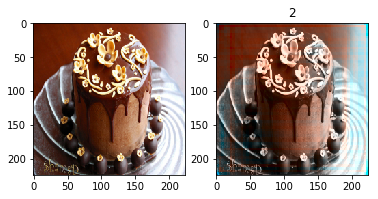

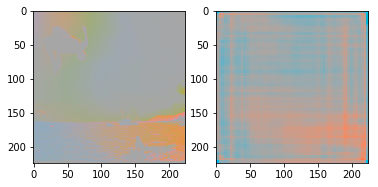

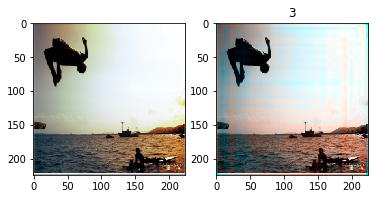

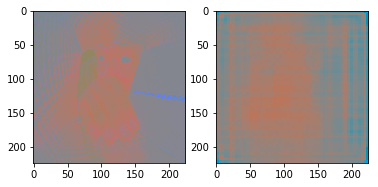

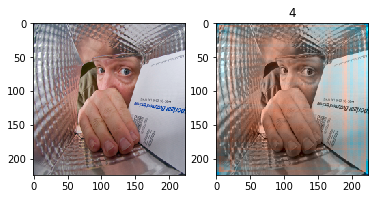

In [0]:
# make sure k equals the 'a' number in the file name.

net = Colorizer(k = 32)
# optimizer = optim.Adam(net.parameters(), lr=learning_rate)

checkpoint = torch.load("/content/drive/My Drive/CNN colorize Data/models/a32-tiny20-b5-l1e4-e200.tar")
net.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

net.eval()
net.to(device)
# print("")

for i in range(5):
    show_prediction(i, train_set, net)